import necessary libaries and importing dataset from google drive



In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from plotly import graph_objs as go
import plotly.express as px
from google.colab import drive
drive.mount('/content/gdrive')

from wordcloud import WordCloud, STOPWORDS
stopwords=list(STOPWORDS)

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer as CVTZ

plt.rc('figure', figsize=(20,11))

import warnings
warnings.simplefilter('ignore')
file_path = '/content/gdrive/MyDrive/1111.csv'
hotel_data = pd.read_csv(file_path)


Mounted at /content/gdrive


In [ ]:
hotel_data.head()


,Review,Rating,timestamp
0,nice hotel expensive parking got good deal sta...,4,9/11/2018
1,ok nothing special charge diamond member hilto...,2,12/30/2018
2,nice rooms not 4* experience hotel monaco seat...,3,6/26/2018
3,"unique, great stay, wonderful time hotel monac...",5,2/24/2018
4,"great stay great stay, went seahawk game aweso...",5,6/1/2018


In [ ]:
hotel_data.shape

(20491, 3)

In [ ]:
hotel_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Rating,20491.0,3.952223,1.23303,1.0,3.0,4.0,5.0,5.0


In [ ]:
hotel_data.describe(include='O')

,Review,timestamp
count,20491,20491
unique,20491,365
top,nice hotel expensive parking got good deal sta...,8/2/2018
freq,1,78


In [ ]:
hotel_data.isnull().sum()

Review       0
Rating       0
timestamp    0
dtype: int64

#UTILIZING EXPLORATORY DATA ANALYSIS(EDA)

In [ ]:
data=hotel_data.copy(deep=True)

In [ ]:
#Lets clean the data
punctuations="""!()-![]{};:,+'"\,<>./?@#$%^&*_~Â"""
lemmatizer=WordNetLemmatizer()
ps=PorterStemmer()

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def get_clean_reviews(review):
    splited=review.split(' ')

    #removing punctuations the translate isuse for the removal
    parsedReview="".join([word.translate(str.maketrans('', '', punctuations))+ " " for word in splited])

    #cleaning stopwords
    clean_words=[]
    for word in parsedReview.split():
        if word.isalpha() and word not in stopwords:
#isalpha( return true if all character are alphabet)
           clean_words.append(lemmatizer.lemmatize(word.lower()))
    return ' '.join(clean_words)
data['cleaned_Review']=data.Review.apply(get_clean_reviews)

In [ ]:
data.head()

,Review,Rating,timestamp,cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,9/11/2018,nice hotel expensive parking got good deal sta...
1,ok nothing special charge diamond member hilto...,2,12/30/2018,ok nothing special charge diamond member hilto...
2,nice rooms not 4* experience hotel monaco seat...,3,6/26/2018,nice room experience hotel monaco seattle good...
3,"unique, great stay, wonderful time hotel monac...",5,2/24/2018,unique great stay wonderful time hotel monaco ...
4,"great stay great stay, went seahawk game aweso...",5,6/1/2018,great stay great stay went seahawk game awesom...


In [ ]:
def get_char_count(review):
    return len(review)

def get_word_count(review):
    return len(review.split(' '))

def get_average_word_length(review):
    aux=0
    for word in review.split(' '):
        aux += len(word)
    return aux/len(review.split(' '))

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#lets add sentiment using vader sentiment
sentiment_object=SentimentIntensityAnalyzer()

def get_sentiment_vader(review):
    sentiment_dict= sentiment_object.polarity_scores(review)
    if sentiment_dict['compound'] >=0.05 :
        return ('Positive')
    elif sentiment_dict['compound'] <=0.05 :
        return ('Negative')
    else:
        return('Neutral')


In [ ]:
#let add sentiment using Textblob sentimet
def get_sentiment_textblob(review):
    sentimet_score=TextBlob(review).sentiment.polarity

    if sentimet_score<0:
        return 'Negative'
    elif sentimet_score>=0 and sentimet_score<=0.2:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
#lets add sentiment for rating
def get_sentiment_rating(rating):
    if rating in [4,5]:
        return 'Positive'
    elif rating in [1,2]:
        return 'Negative'A

    else:
        return 'Neutral'

In [ ]:
data['sentiment_vader']= data['cleaned_Review'].apply(get_sentiment_vader)
data['sentiment_textblob']= data['cleaned_Review'].apply(get_sentiment_textblob)
data['sentiment_fromrating']= data['cleaned_Review'].apply(get_sentiment_rating)

In [ ]:
data['char_count']=data['cleaned_Review'].apply(get_char_count)
data['word_count']=data['cleaned_Review'].apply(get_word_count)

In [ ]:
data.head()

,Review,Rating,timestamp,cleaned_Review,sentiment_vader,sentiment_textblob,sentiment_fromrating,char_count,word_count
0,nice hotel expensive parking got good deal sta...,4,9/11/2018,nice hotel expensive parking got good deal sta...,Positive,Positive,Neutral,537,79
1,ok nothing special charge diamond member hilto...,2,12/30/2018,ok nothing special charge diamond member hilto...,Positive,Positive,Neutral,1556,226
2,nice rooms not 4* experience hotel monaco seat...,3,6/26/2018,nice room experience hotel monaco seattle good...,Positive,Positive,Neutral,1306,195
3,"unique, great stay, wonderful time hotel monac...",5,2/24/2018,unique great stay wonderful time hotel monaco ...,Positive,Positive,Neutral,552,83
4,"great stay great stay, went seahawk game aweso...",5,6/1/2018,great stay great stay went seahawk game awesom...,Positive,Positive,Neutral,1171,178


In [ ]:

data['sentiment_final']=data[['sentiment_vader', 'sentiment_textblob', 'sentiment_fromrating']].mode(axis=1)[0]

In [ ]:
data.head()

,Review,Rating,timestamp,cleaned_Review,sentiment_vader,sentiment_textblob,sentiment_fromrating,char_count,word_count,sentiment_final
0,nice hotel expensive parking got good deal sta...,4,9/11/2018,nice hotel expensive parking got good deal sta...,Positive,Positive,Neutral,537,79,Positive
1,ok nothing special charge diamond member hilto...,2,12/30/2018,ok nothing special charge diamond member hilto...,Positive,Positive,Neutral,1556,226,Positive
2,nice rooms not 4* experience hotel monaco seat...,3,6/26/2018,nice room experience hotel monaco seattle good...,Positive,Positive,Neutral,1306,195,Positive
3,"unique, great stay, wonderful time hotel monac...",5,2/24/2018,unique great stay wonderful time hotel monaco ...,Positive,Positive,Neutral,552,83,Positive
4,"great stay great stay, went seahawk game aweso...",5,6/1/2018,great stay great stay went seahawk game awesom...,Positive,Positive,Neutral,1171,178,Positive


In [ ]:
data.to_csv("/content/Trip-Advisor-rating-sentiments.csv",index=False)


##EXPLORInG LOGISTIC FEATURES OF THE DATA

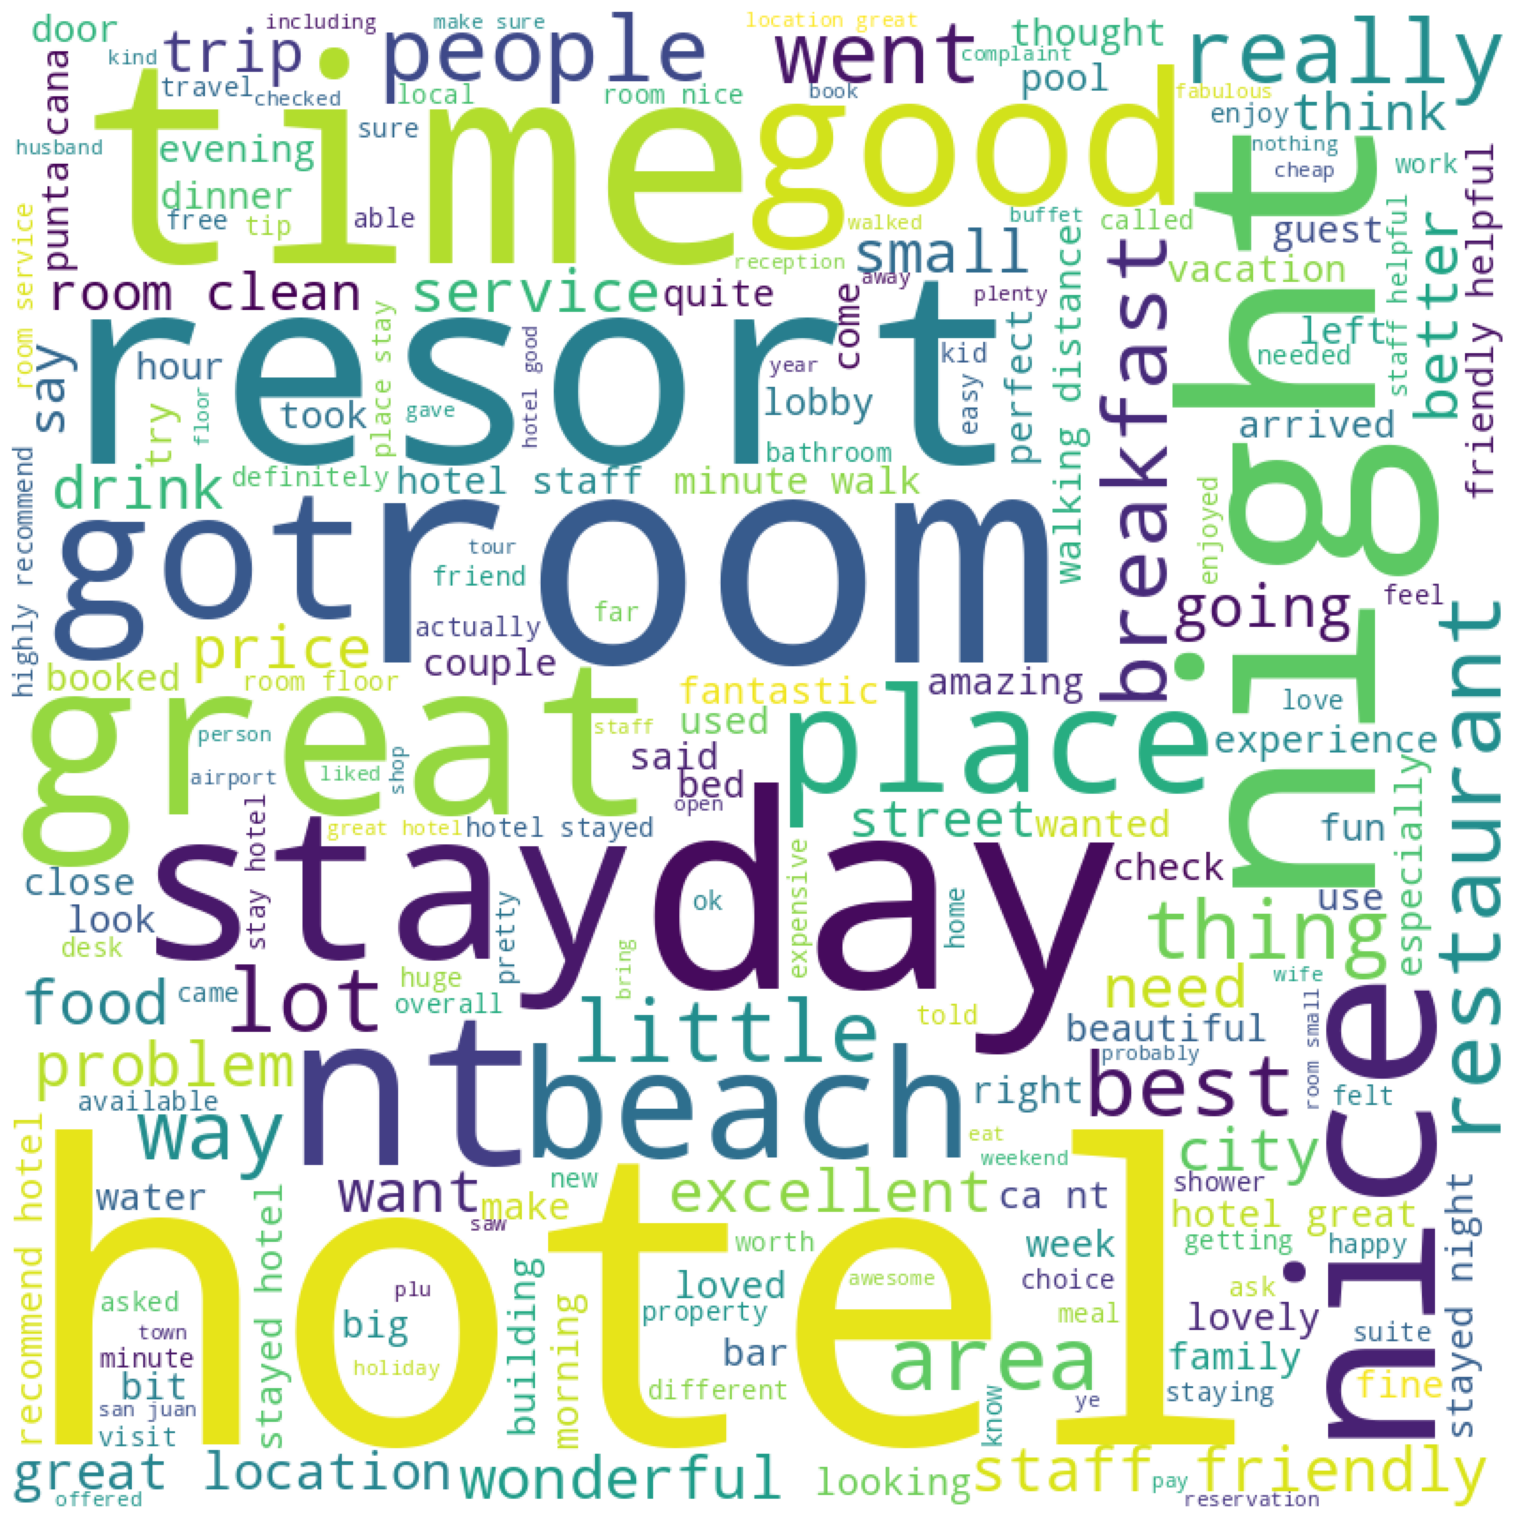

In [ ]:
custom_stop_word_list=['hotel', 'room', 'day', 'time']

word_list=''
for word in list(data[data['sentiment_final']=='Positive']['cleaned_Review']):
    splited=word.lower()
    word_list+=splited

wordcloud=WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=5).generate(word_list)
plt.figure(figsize=(25,15), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

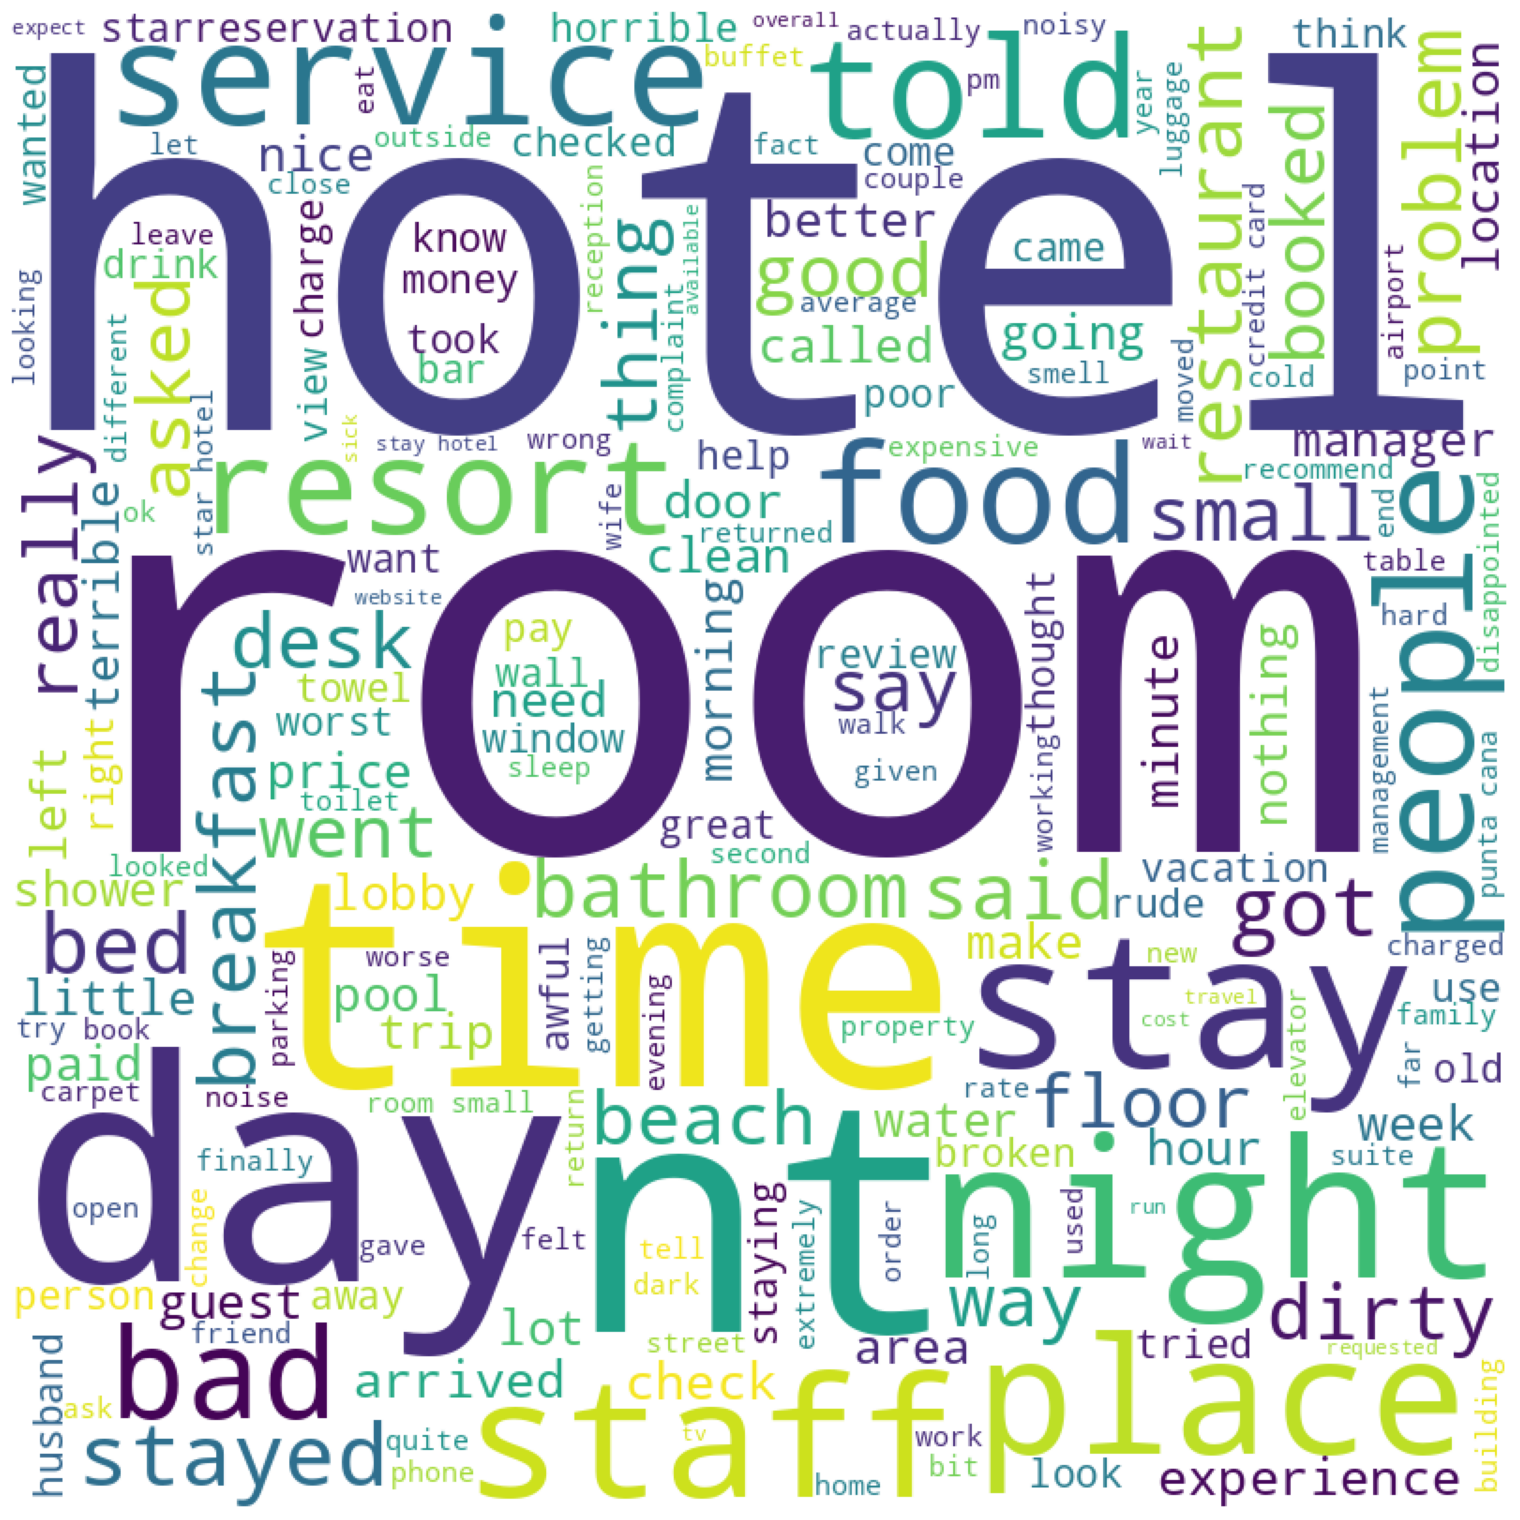

In [ ]:
word_list=''
for word in list(data[data['sentiment_final']=='Negative']['cleaned_Review']):
    splited=word.lower()
    word_list+=splited

wordcloud=WordCloud(width=800, height=800, background_color='white', stopwords=stopwords, min_font_size=5).generate(word_list)
plt.figure(figsize=(25,15), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

plt.show()

#let use plotly
#A box is a statistaical representation of the distribution of a variable through its quartiles

In [ ]:
px.box(data, x='Rating', y='char_count', notched=True, facet_row='sentiment_final',
      title="Rating Sentiment Distribution")

Text(0.5, 1.0, 'Summary of the review analysis')

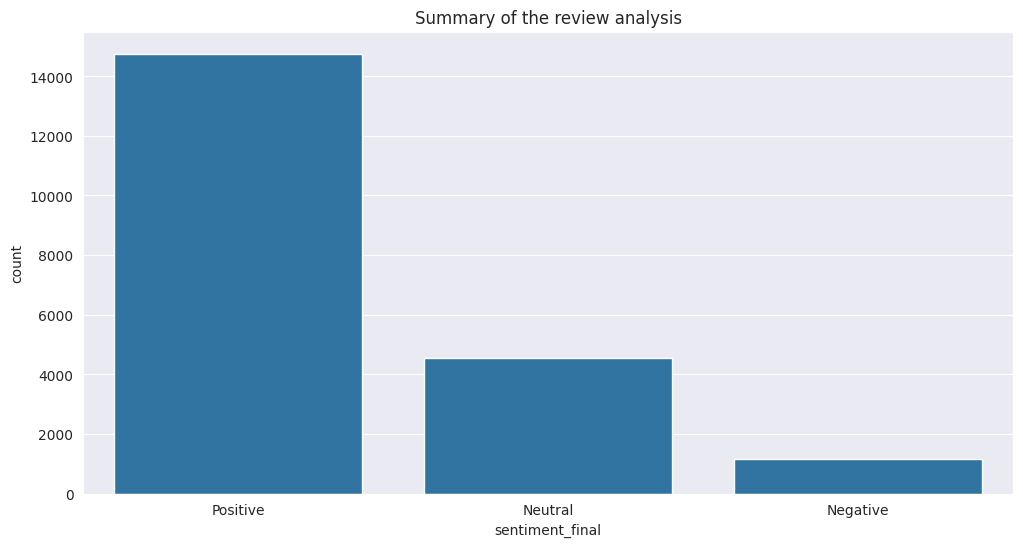

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment_final', data=data);
plt.title('Summary of the review analysis')

In [ ]:
data['sentiment_final'].value_counts()

sentiment_final
Positive    14761
Neutral      4557
Negative     1173
Name: count, dtype: int64

##Now LETD BUILD NLP MODEL

In [ ]:
final_model_data=data[['cleaned_Review','sentiment_final','timestamp']].copy()

In [ ]:
final_model_data.tail()

,cleaned_Review,sentiment_final,timestamp
20486,best kept secret time staying charm ca nt beat...,Positive,11/9/2018
20487,great location price view hotel great quick pl...,Positive,1/23/2018
20488,ok look nice modern outside desk staff nt part...,Neutral,12/2/2018
20489,hotel theft ruined vacation hotel opened sept ...,Neutral,10/1/2018
20490,people talking ca nt believe excellent rating ...,Neutral,12/31/2018


In [ ]:
final_model_data.to_csv('final_model_data.csv') #backup

In [ ]:
final_model_data=pd.read_csv('final_model_data.csv')


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
x=vectorizer.fit_transform(final_model_data['cleaned_Review'])

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x, final_model_data['sentiment_final'],random_state=42)

In [ ]:
model= DecisionTreeClassifier(random_state=102).fit(x_train, y_train)
predictiontree=model.predict(x_test)
print(confusion_matrix(y_test, predictiontree))
print(classification_report(y_test, predictiontree))
print(accuracy_score(y_test, predictiontree))

[[ 111  119   50]
 [ 124  494  524]
 [  44  477 3180]]
              precision    recall  f1-score   support

    Negative       0.40      0.40      0.40       280
     Neutral       0.45      0.43      0.44      1142
    Positive       0.85      0.86      0.85      3701

    accuracy                           0.74      5123
   macro avg       0.57      0.56      0.56      5123
weighted avg       0.73      0.74      0.74      5123

0.7388249072808901


In [ ]:
model= RandomForestClassifier(random_state=101).fit(x_train, y_train)
predictiontree=model.predict(x_test)
print(confusion_matrix(y_test, predictiontree))
print(classification_report(y_test, predictiontree))
print(accuracy_score(y_test, predictiontree))

[[  18   44  218]
 [   1   69 1072]
 [   0    4 3697]]
              precision    recall  f1-score   support

    Negative       0.95      0.06      0.12       280
     Neutral       0.59      0.06      0.11      1142
    Positive       0.74      1.00      0.85      3701

    accuracy                           0.74      5123
   macro avg       0.76      0.37      0.36      5123
weighted avg       0.72      0.74      0.65      5123

0.7386297091547921


##MODEL TUNING

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

random_grid_search={'criterion':['entropy', 'gini'],
                   'max_depth':[2,5,10],
                   'max_features':['auto','sqrt'],
                   'min_samples_leaf': [4,6,8],
                   'min_samples_split':[5,7,10],
                    'n_estimators':[5,10,20,30]
                   }

clf=RandomForestClassifier()

model=RandomizedSearchCV(estimator=clf, param_distributions=random_grid_search, n_iter=10,
                         cv=4, verbose=1, random_state=101, n_jobs=-1, return_train_score=True)

model.fit(x_train, y_train)

predictionforest=model.best_estimator_.predict(x_test)
print(confusion_matrix(y_test, predictionforest))
print(classification_report(y_test, predictionforest))

acc=accuracy_score(y_test, predictionforest)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
[[   0    7  273]
 [   0   11 1131]
 [   0    9 3692]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       280
     Neutral       0.41      0.01      0.02      1142
    Positive       0.72      1.00      0.84      3701

    accuracy                           0.72      5123
   macro avg       0.38      0.34      0.29      5123
weighted avg       0.61      0.72      0.61      5123



In [ ]:
from datetime import datetime

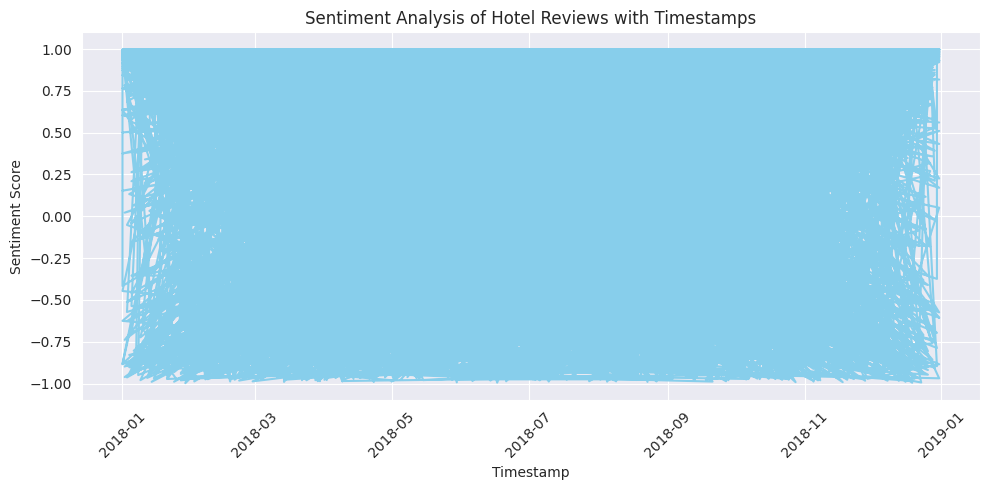

In [ ]:
hotel_data['timestamp'] = pd.to_datetime(hotel_data['timestamp'])

# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Calculate sentiment scores for each review
hotel_data['sentiment'] = hotel_data['Review'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Plot sentiment scores with timestamps
plt.figure(figsize=(10, 5))
plt.plot(hotel_data['timestamp'], hotel_data['sentiment'], color='skyblue')
plt.xlabel('Timestamp')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Analysis of Hotel Reviews with Timestamps')
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pip install vadersentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def classify_opinions(review_text):
    sentiment_scores = analyzer.polarity_scores(review_text)
    if sentiment_scores['compound'] >= 0.5:
        return 'strong positive'
    elif sentiment_scores['compound'] >= 0.1:
        return 'weak positive'
    elif sentiment_scores['compound'] <= -0.5:
        return 'strong negative'
    elif sentiment_scores['compound'] <= -0.1:
        return 'weak negative'
    else:
        return 'neutral'

opinion_category = classify_opinions(hotel_data)
print("Opinion Category:", opinion_category)


Opinion Category: neutral


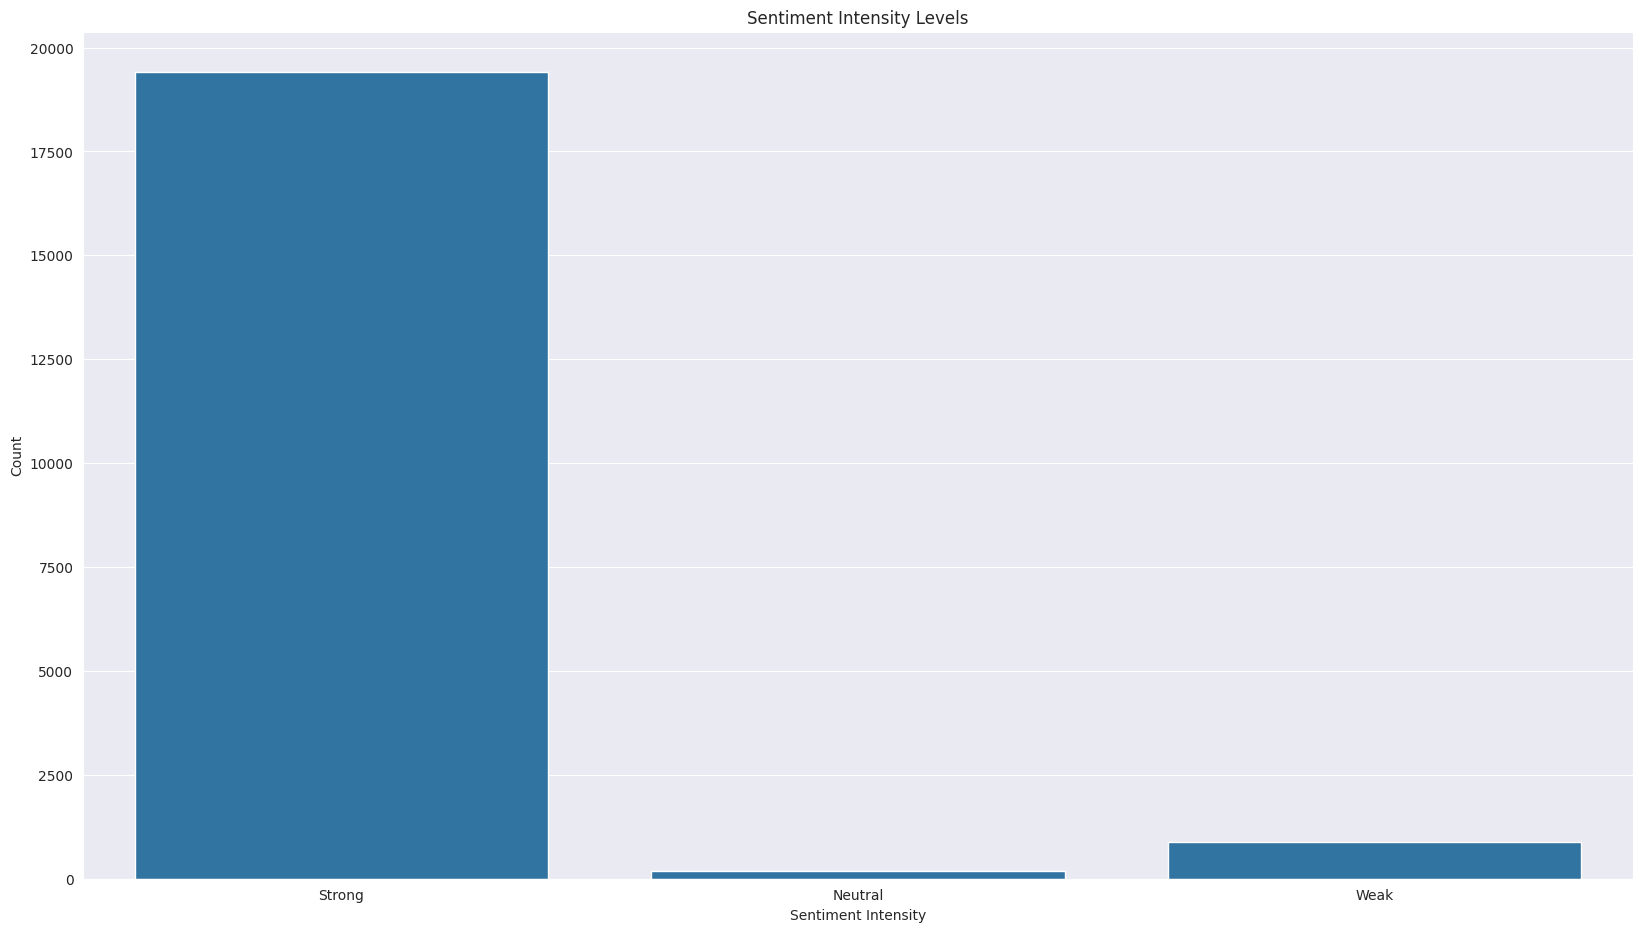

                                                  Review  Rating  timestamp  \
0      nice hotel expensive parking got good deal sta...       4 2018-09-11   
1      ok nothing special charge diamond member hilto...       2 2018-12-30   
2      nice rooms not 4* experience hotel monaco seat...       3 2018-06-26   
3      unique, great stay, wonderful time hotel monac...       5 2018-02-24   
4      great stay great stay, went seahawk game aweso...       5 2018-06-01   
...                                                  ...     ...        ...   
20486  best kept secret 3rd time staying charm, not 5...       5 2018-11-09   
20487  great location price view hotel great quick pl...       4 2018-01-23   
20488  ok just looks nice modern outside, desk staff ...       2 2018-12-02   
20489  hotel theft ruined vacation hotel opened sept ...       1 2018-10-01   
20490  people talking, ca n't believe excellent ratin...       2 2018-12-31   

       sentiment sentiment_category sentiment_inten

In [ ]:


# Initialize sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment and return sentiment intensity level
def classify_sentiment(review_text):
    sentiment_scores = analyzer.polarity_scores(review_text)
    compound_score = sentiment_scores['compound']

    if compound_score >= 0.5:
        return 'Positive', 'Strong'
    elif compound_score >= 0.1:
        return 'Positive', 'Weak'
    elif compound_score <= -0.5:
        return 'Negative', 'Strong'
    elif compound_score <= -0.1:
        return 'Negative', 'Weak'
    else:
        return 'Neutral', 'Neutral'

# Apply sentiment analysis and add columns to DataFrame
hotel_data['sentiment_category'], hotel_data['sentiment_intensity'] = zip(*hotel_data['Review'].apply(classify_sentiment))

# Visualize sentiment intensity levels
sns.countplot(x='sentiment_intensity', data=hotel_data)
plt.title('Sentiment Intensity Levels')
plt.xlabel('Sentiment Intensity')
plt.ylabel('Count')
plt.show()

# Print the DataFrame with sentiment analysis results
print(hotel_data)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Sample data
data = {'Review': ["The hotel staff was very friendly and helpful.",
                   "The room was clean and comfortable, but the service was slow.",
                   "I had a terrible experience at this hotel.",
                   "Overall, it was a great stay with excellent amenities."]}
df = pd.DataFrame(data)

# Initialize sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis and add additional features
def analyze_sentiment(review_text):
    # Perform sentiment analysis
    sentiment_scores = analyzer.polarity_scores(review_text)
    compound_score = sentiment_scores['compound']

    # Classify sentiment intensity
    if compound_score >= 0.5:
        sentiment_intensity = 'Strong'
    elif compound_score >= 0.1:
        sentiment_intensity = 'Weak'
    elif compound_score <= -0.5:
        sentiment_intensity = 'Strong'
    elif compound_score <= -0.1:
        sentiment_intensity = 'Weak'
    else:
        sentiment_intensity = 'Neutral'

    # Calculate review length and word count
    review_length = len(review_text)
    word_count = len(review_text.split())

    # Add sentiment scores and additional features to a dictionary
    sentiment_data = {
        'Review': review_text,
        'Sentiment Category': 'Positive' if compound_score >= 0 else 'Negative' if compound_score <= 0 else 'Neutral',
        'Sentiment Score (Positive)': sentiment_scores['pos'],
        'Sentiment Score (Negative)': sentiment_scores['neg'],
        'Sentiment Score (Neutral)': sentiment_scores['neu'],
        'Compound Sentiment Score': compound_score,
        'Sentiment Intensity': sentiment_intensity,
        'Review Length': review_length,
        'Word Count': word_count
    }

    return sentiment_data

# Apply sentiment analysis and additional features to each review
df['Sentiment Analysis'] = df['Review'].apply(analyze_sentiment)

# Display the processed DataFrame
print(df[['Review', 'Sentiment Analysis']])


                                              Review  \
0     The hotel staff was very friendly and helpful.   
1  The room was clean and comfortable, but the se...   
2         I had a terrible experience at this hotel.   
3  Overall, it was a great stay with excellent am...   

                                  Sentiment Analysis  
0  {'Review': 'The hotel staff was very friendly ...  
1  {'Review': 'The room was clean and comfortable...  
2  {'Review': 'I had a terrible experience at thi...  
3  {'Review': 'Overall, it was a great stay with ...  
